Pierre-Elliott THIBOUD  
Julien PERIER-CAMBY  

# IBI - TP1
## Imports et données

In [1]:
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy as np # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

#np.seterr(all='call')

Affichage d'une image

In [2]:
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = np.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image.reshape((28,28)),interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()

In [3]:
LOGGING = False
def printf(*vals):
    if LOGGING:
        print(*vals)

### Chargement des données

In [4]:
TRAIN_BATCH_SIZE = 1

data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')

train_data = torch.Tensor(data[0][0])
# labels de la base d'apprentissage
train_data_label = torch.Tensor(data[0][1])
# images de la base de test
test_data = torch.Tensor(data[1][0])
# labels de la base de test
test_data_label = torch.Tensor(data[1][1])
# on crée la base de données d'apprentissage (pour torch)
train_dataset = torch.utils.data.TensorDataset(train_data,train_data_label)
# on crée la base de données de test (pour torch)
test_dataset = torch.utils.data.TensorDataset(test_data,test_data_label)
# on crée le lecteur de la base de données d'apprentissage (pour torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
# on crée le lecteur de la base de données de test (pour torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

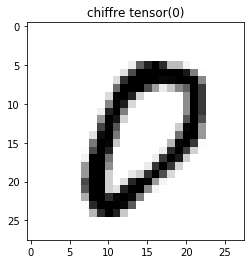

In [5]:
affichage(train_data[0], train_data_label[0])

## - __Partie 1__ : Perceptron

In [6]:
def initWeightsDefault(input_dim, output_dim):
    return np.random.normal(loc=0.0,scale=1.0,size=(output_dim,input_dim+1))

class Perceptron:
    def __init__(self, input_dim, output_dim, learning_rate, initWeights=initWeightsDefault):
        self.weights = initWeights(input_dim, output_dim)
        self.learning_rate = learning_rate
        self.output_dim = output_dim
        self.input_dim = input_dim
        
    def detach(self, detaching=False):
        #Do nothing
        self

    def forward(self, x):
        # Rajoute le biais
        x = np.append(x.flatten(),1)
        return np.dot(self.weights, x)
    
    def backward(self, x, y ,t):
        error = np.array(t) - y
        self.backward_w_error(np.array(x).flatten(), error)

    # Séparation du calcul de l'erreur et de la rétro-propagation pour réutiliser le Perceptron dans le MLP
    def backward_w_error(self, x, error):
        # Rajoute le biais
        x = np.append(x, 1)
        
        delta = error.reshape(self.output_dim,1).dot(x.reshape(1,self.input_dim+1)) * self.learning_rate
        
        # Mise à jour des poids
        self.weights += delta

In [7]:
# Pour étudier la modification des poids et des différents paramètres lors du développement
def test_training(model, max_it=0):
    for (idx,(image,label)) in enumerate(train_loader):
        if idx > max_it:
            break
        
        print("Test training - Forward")
        y = model.forward(image)
        print("Test training - Backward")
        model.backward(image, y, label)

In [8]:
def training(model, epochs, show_progress=False):
    if show_progress:
        for epoch in tqdm(range(epochs)):
            for (idx,(image,label)) in enumerate(train_loader):
                # on demande les prochaines données de la base
                y = model.forward(image)
                model.backward(image, y, label)
    else:
        for epoch in range(epochs):
            for (idx,(image,label)) in enumerate(train_loader):
                # on demande les prochaines données de la base
                y = model.forward(image)
                model.backward(image, y, label)

In [9]:
def test(model, print_accuracy=False, show_progress=False):
    true_positives = 0
    model.detach()
    if show_progress:
        for (idx,(image,label)) in enumerate(tqdm(test_loader)):
            if np.argmax(label) == np.argmax(model.forward(image)):
                true_positives += 1
    else:
        for (idx,(image,label)) in enumerate(test_loader):
            if np.argmax(label) == np.argmax(model.forward(image)):
                true_positives += 1
    model.detach(False)
            
    accuracy = true_positives/len(test_loader)
    if print_accuracy:
        print("Accuracy: ", accuracy)
    return accuracy

### Hyperparamètres

In [10]:
input_dim = 784
nb_class = 10

learning_rate = 0.009

### Perceptron - Test simple

In [52]:
model = Perceptron(input_dim, nb_class, learning_rate)

training(model, 6, show_progress=False)

test(model, print_accuracy=True)

Accuracy:  0.7235714285714285


0.7235714285714285

### Grid search

In [10]:
def plotAccuracy(accuracies, learning_rates, nb_epochs, title=""):
    x_axis = range(1, nb_epochs+1)
    for idx,lr in enumerate(learning_rates):
        plt.plot(x_axis, accuracies[idx], label=f"lr-{lr}")
    plt.legend(loc=2)
    plt.xlabel('Pas de temps (epochs)')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.show()

In [11]:
def grid_search(learning_rates, nb_epochs=10, show_progress=False, print_accuracy=False, initModel=Perceptron, initWeights=initWeightsDefault):
    i = 0
    accuracies = []
    for lr in learning_rates:
        #print("------------------\nLearning rate :", lr)
        model = initModel(input_dim, nb_class, lr, initWeights=initWeights)
        i+=1
        #print(f"Model {i} created")
        accuracy = []

        for k in range(1,nb_epochs+1):
            training(model, 1, show_progress=show_progress)
            #print("Epoch", k, ": ", end='')
            #print(f"Model{i}/Epoch{k}")
            accu = test(model, print_accuracy=False, show_progress=show_progress)
            accuracy.append(accu)
        accuracies.append(accuracy)
    return accuracies

#### Fonctions d'initialisation des poids

In [12]:
def initUniform(low=0, high=1):
    return lambda input_dim, output_dim: np.random.uniform(low, high, size=(output_dim,input_dim+1))

def initNormal(loc=0, scale=1):
    return lambda input_dim, output_dim: np.random.normal(loc, scale, size=(output_dim,input_dim+1))

initFunctionsDict = {
    "U": initUniform,
    "N": initNormal
}

Les différents taux d'apprentissages et fonctions d'initialisation à tester

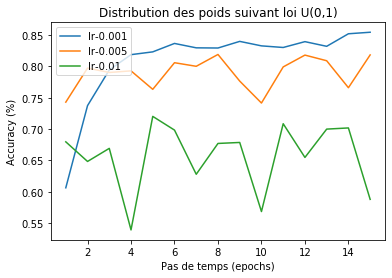

Accuracy maximum atteinte : 0.8544285714285714
-------------------------------------------


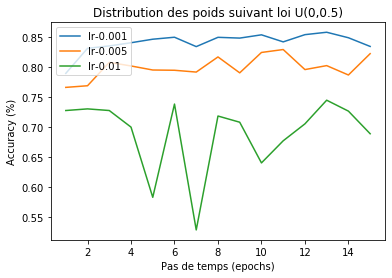

Accuracy maximum atteinte : 0.8574285714285714
-------------------------------------------


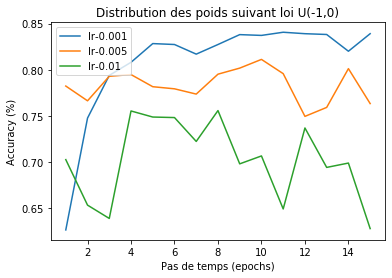

Accuracy maximum atteinte : 0.8405714285714285
-------------------------------------------


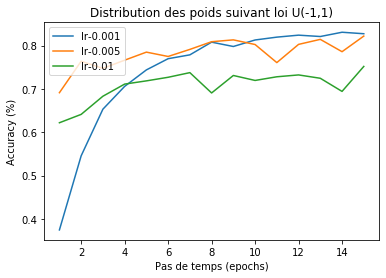

Accuracy maximum atteinte : 0.8305714285714285
-------------------------------------------


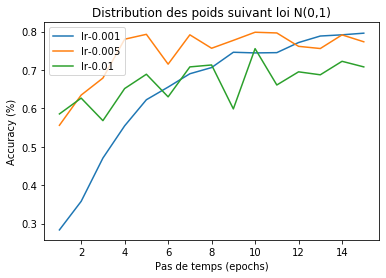

Accuracy maximum atteinte : 0.7984285714285714
-------------------------------------------


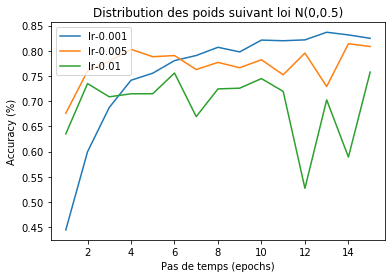

Accuracy maximum atteinte : 0.8367142857142857
-------------------------------------------


In [28]:
learning_rates = (1e-3, 5e-3, 1e-2)
nb_epochs = 15
initFunctions = {
    "U": [
        [0,1], [0,0.5], [-1,0], [-1,1]
    ],
    "N": [
        [0,1], [0,0.5]
    ]
}

for typeF, typeFParam in initFunctions.items():
    for initFP in typeFParam:
        initF = (initFunctionsDict[typeF])(initFP[0], initFP[1])
        accuracies = grid_search(learning_rates, nb_epochs, initWeights=initF)
        plotAccuracy(accuracies, learning_rates, nb_epochs, title=f"Distribution des poids suivant loi {typeF}({initFP[0]},{initFP[1]})")
        max_accuracy = np.max(accuracies)
        print(f"Accuracy maximum atteinte : {max_accuracy}")
        print("-------------------------------------------")

### Discussion

Les graphiques précédents nous permettent de remarquer l'impact de l'ordre de grandeur du `learning_rate` utilisé. Lorsque celui-ci est trop élevé, l'apprentissage du Perceptron est trop aléatoire, il n'arrive pas (ou difficilement) à converger. Ainsi, on peut voir qu'un `learning_rate = 0.01` (en vert) converge assez rarement et ne dépasse pas les 75% de précision, tandis qu'un `learning_rate = 0.001` (en bleu) converge presque tout le temps.

Ces graphiques permettent également de remarquer que la fonction d'initialisation des poids a une influence sur l'impact de l'ordre de grandeur du `learning_rate` utilisé. En effet, lorsque les poids sont initialisés à des valeurs proches de leur valeur *optimale*, le `learning_rate` doit être plus faible que dans le cas de poids plus répartis. On remarque cela avec la répartition suivant une loi uniforme U(-1, 1) où le Perceptron s'améliore continuellement pendant 7 epochs avant de *dérailler*.

## - __Partie 2__ : Shallow Nerwork

In [13]:
class MLP:
    def __init__(self, input_dim, nb_neurons, output_dim, learning_rate, initWeights=initWeightsDefault):
        self.hidden_layer = Perceptron(input_dim, nb_neurons, learning_rate, initWeights=initWeights)
        self.output_layer = Perceptron(nb_neurons, output_dim, learning_rate, initWeights=initWeights)
        self.hidden_output = None
        self.nb_neurons = nb_neurons
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        
    def detach(self, detaching=False):
        #Do nothing
        self
        
    def forward(self, x):
        hidden_layer_output = self.hidden_layer.forward(x)
        self.hidden_output = 1/(1 + np.exp(-1*hidden_layer_output))
        return self.output_layer.forward(self.hidden_output)
    
    def backward(self, x, y ,t):
        output_error = np.array(t) - y
        weights = self.output_layer.weights[:,:-1]
        summ = output_error.dot(weights)
        hidden_error_1 = (1-self.hidden_output)
        hidden_error_2 = hidden_error_1 * self.hidden_output
        hidden_error = hidden_error_2*summ
        
        self.output_layer.backward_w_error(self.hidden_output, output_error)
        self.hidden_layer.backward_w_error(x, hidden_error)

### Paramètres MLP

In [14]:
input_dim = 784
nb_class = 10

learning_rate = 1e-3
nb_neurons = 120

### MLP - Test simple

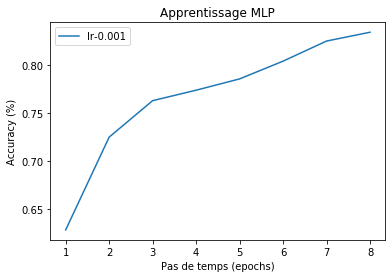

In [16]:
LOGGING = False
epochs = 8

model = MLP(input_dim, nb_neurons, nb_class, learning_rate)

accuracy = []
for epoch in range(1, epochs+1):
    training(model, epochs=epoch)
    accu = test(model, print_accuracy=True)
    accuracy.append(accu)

plotAccuracy([accuracy], [learning_rate], epochs, title=f"Apprentissage MLP")

### Grid search

In [17]:
def initModelFunction(nb_neurons):
    def initModel(input_dim, nb_class, lr, initWeights):
        return MLP(input_dim, nb_neurons, nb_class, lr, initWeights=initWeights)
    return initModel

def MLP_grid_search(learning_rates, hidden_layer_sizes, nb_epochs=6, show_progress=False, initModelF=initModelFunction):
    for size in hidden_layer_sizes:
        print("==================\nHidden layer size:", size)
        initModel = initModelF(size)
        accuracies = grid_search(learning_rates, nb_epochs=nb_epochs, show_progress=show_progress, initModel=initModel)
        plotAccuracy(accuracies, learning_rates, nb_epochs, title=f"Distribution des poids suivant loi N(0,1)\n{size} neurones cachés")
        max_accuracy = np.max(accuracies)
        print(f"Accuracy maximum atteinte : {max_accuracy}")
        print("-------------------------------------------")

Hidden layer size: 50


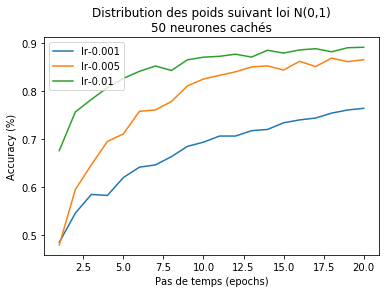

Accuracy maximum atteinte : 0.8911428571428571
-------------------------------------------
Hidden layer size: 100


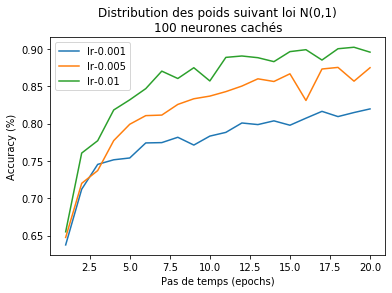

Accuracy maximum atteinte : 0.9021428571428571
-------------------------------------------
Hidden layer size: 350


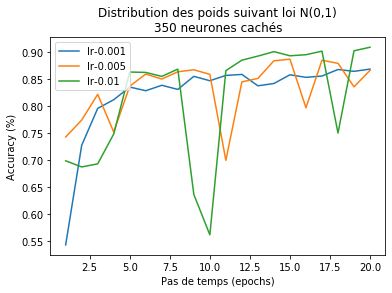

Accuracy maximum atteinte : 0.9091428571428571
-------------------------------------------


In [20]:
lr = (1e-3, 5e-3, 1e-2)
hidden_layer_sizes = (50, 100, 350)
# hidden_layer_sizes = (25, 32)

MLP_grid_search(lr, hidden_layer_sizes, nb_epochs=20)

### Discussion

On peut directment constater que l'ajout d'une couche cachée permet une nette amélioration des performances. Cette fois ci le nombre d'itérations est plus élévé (20 contre 15 précédement), mais si on observe la performance du MLP pour 15 itérations, elle est quand même supérieure à celle du perceptron.  


On constate qu'une couche cachée plus large permet d'obtenir de meilleures performances, en effet, le modèle a plus de poids et peut donc apprendre des fonctions plus complexes. Néanmoins, cela implique aussi un temps d'apprentissage plus long car il y a plus de paramètres à apprendre. En effet, on constate que passer de `hidden_layer_size=50` à `hidden_layer_size=100` permet d'obtenir une meilleure accuracy. Alors que passer de `hidden_layer_size=100` à `hidden_layer_size=300` ne permet pas d'amélioration significative sur 20 epochs (mais pourrait donner de meilleurs résultats avec plus de pas de temps).  


Pour ce qui est du taux d'apprentissage, on constate que les valeurs qui donnaient les méilleurs résultats avec `hidden_layer_size=50` induisent une forte instabilité pour `hidden_layer_size=300`. On peut donc penser que pour des couches plus larges, il faudrait un taux d'apprentissage plus faible mais sur un nombre de pas de temps plus élévés. Mais cela rallongerait d'avantage le temps d'apprentissage (peut-être qu'une approche _deep_ plutôt que _wide_ permettrait de meilleures capacités d'apprentissage sans trop rallonger le temps nécessaire ?).

## Partie 3 - Deep Network

Utilisation de CUDA si disponible :

In [17]:
print("Cuda for PyTorch is available: ", torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        for d in self.dl:
            yield to_device(d, self.device)
        
    def __len__(self):
        return len(self.dl)

Cuda for PyTorch is available:  True


In [18]:
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

cuda


In [19]:
def training_torch(model, epochs, show_progress=False):
    for epoch in range(epochs):
        for (idx,(image,label)) in enumerate(train_dl):
            # on demande les prochaines données de la base
            y = model.forward(image)
            model.backward(image, y, label)

In [20]:
def test_torch(model, print_accuracy=False, show_progress=False):
    true_positives = 0
    for (idx,(image,label)) in enumerate(test_dl):
        if torch.argmax(label) == torch.argmax(model.forward(image)):
            true_positives += 1
            
    accuracy = true_positives/len(test_loader)
    if print_accuracy:
        print("Accuracy: ", accuracy)
    return accuracy

In [35]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate, lossFunction=nn.MSELoss, optimizer=optim.SGD, activationFunction=F.relu):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, output_dim).to(device)
        self.learning_rate = learning_rate
        self.criterion = lossFunction()
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.function = activationFunction

    def forward(self, x):
        x = self.function(self.fc1(x))
        x = self.function(self.fc2(x))
        x = self.fc3(x)
        return x

    def backward(self, x, output, target):
        self.optimizer.zero_grad()  # zero the gradient buffers
        loss = self.criterion(output, target)
        loss.backward()
        self.optimizer.step()

### Deep Network - Test simple

In [22]:
input_dim = 784
output_dim = 10
lr = 10e-2

model = Net(input_dim, output_dim, lr)
training_torch(model, 4)

In [24]:
test_torch(model)

0.9677142857142857

### Grid Search

In [29]:
def DN_grid_search(learning_rates, nb_epochs=6):
    accuracies = []
    for lr in learning_rates:
        print(f"Learning rate: {lr}")
        model = Net(input_dim, output_dim, lr)
        accuracy = []
        for epoch in range(1, nb_epochs+1):
            training_torch(model, 1)
            accu = test_torch(model, print_accuracy=False)
            print(f"Epoch {epoch}/{nb_epochs}: {accu}")
            accuracy.append(accu)
        accuracies.append(accuracy)
    
    plotAccuracy(accuracies, learning_rates, nb_epochs, title=f"Deep Network")
    
#     for size in hidden_layer_sizes:
#         print("==================\nHidden layer size:", size)
#         initModel = initModelF(size)
#         accuracies = grid_search(learning_rates, nb_epochs=nb_epochs, show_progress=show_progress, initModel=initModel)
#         plotAccuracy(accuracies, learning_rates, nb_epochs, title=f"Distribution des poids suivant loi N(0,1)\n{size} neurones cachés")

Learning rate: 0.0001
Epoch 1/10: 0.485
Epoch 2/10: 0.6192857142857143
Epoch 3/10: 0.6795714285714286
Epoch 4/10: 0.7295714285714285
Epoch 5/10: 0.7644285714285715
Epoch 6/10: 0.7914285714285715
Epoch 7/10: 0.8077142857142857
Epoch 8/10: 0.8192857142857143
Epoch 9/10: 0.8294285714285714
Epoch 10/10: 0.8377142857142857
Learning rate: 0.001
Epoch 1/10: 0.8422857142857143
Epoch 2/10: 0.8852857142857142
Epoch 3/10: 0.9072857142857143
Epoch 4/10: 0.916
Epoch 5/10: 0.9235714285714286
Epoch 6/10: 0.9291428571428572
Epoch 7/10: 0.9332857142857143
Epoch 8/10: 0.9381428571428572
Epoch 9/10: 0.9411428571428572
Epoch 10/10: 0.943


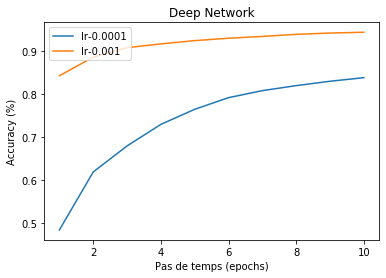

In [31]:
learning_rates = (1e-4, 1e-3)
nb_epochs = 10

DN_grid_search(learning_rates, nb_epochs)

Learning rate: 0.005
Epoch 1/10: 0.9205714285714286
Epoch 2/10: 0.9417142857142857
Epoch 3/10: 0.9535714285714286
Epoch 4/10: 0.9587142857142857
Epoch 5/10: 0.9622857142857143
Epoch 6/10: 0.9664285714285714
Epoch 7/10: 0.9691428571428572
Epoch 8/10: 0.9697142857142858
Epoch 9/10: 0.971
Epoch 10/10: 0.9731428571428572
Learning rate: 0.01
Epoch 1/10: 0.9394285714285714
Epoch 2/10: 0.9554285714285714
Epoch 3/10: 0.966
Epoch 4/10: 0.9704285714285714
Epoch 5/10: 0.9762857142857143
Epoch 6/10: 0.9762857142857143
Epoch 7/10: 0.9774285714285714
Epoch 8/10: 0.9798571428571429
Epoch 9/10: 0.9804285714285714
Epoch 10/10: 0.9807142857142858


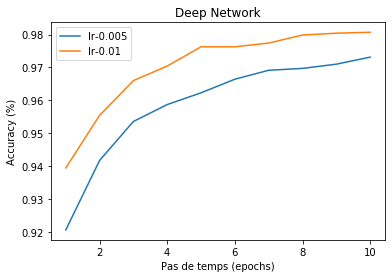

In [32]:
learning_rates = (5e-3, 1e-2)
nb_epochs = 10

DN_grid_search(learning_rates, nb_epochs)

#### Explications

*Pour des raisons de manque de temps, et de mauvais paramétrage de CUDA, nous n'avons pas pu tester et afficher les résultats d'apprentissage en modifiant le nombre de couches, le nombre de neurones par couche ainsi que l'initialisation des poids initiaux.*

D'après les résultats que nous avons, nous pouvons remarquer que sur 10 epochs les learning_rate `0.0001, 0.001, 0.005, 0.01` permettent tous au réseau de converger. Les learning_rate plus élevés sont toutefois plus efficaces, car ils permettent notamment d'atteindre une précision de 98% pour le `learning_rate = 0.01`.

Bien que nous ne l'ayons pas testé, nous pouvons rapprocher ceci de la plupart des tutoriels trouvables sur internet. Dans ceux-ci, il est souvent indiqué de commencer par entraîner le réseau de neurones avec un pas d'apprentissage de `1e-2` pour les 10~15 premiers pas de temps, puis de continuer avec un pas d'apprentissage plus petit pour *peaufiner* les résultats. Il aurait donc été intéressant de voir l'évolution de la précision du réseau en modifiant le learning_rate au cours de l'entraînement (bien que cela aurait rajouté une quantité de paramètres plus que conséquente).

En ce qui concerne le nombre de couches ou le nombre de neurones par couche, en nous basant sur notre propre expérience avec des réseaux de neurones, nous pouvons dire qu'il est pertinent d'avoir un nombre décroissant de neurones par couche plus on s'approche de la couche de sortie. Quand au choix des valeurs, sachant que 100 neurones avaient permis de bons résultats pour la partie 2, nous avons choisit 120 et 84 neurones pour nos couches. L'idéal aurait été de tester différentes valeures, mais cela se serait avéré très chornophage à cause de la durée d'apprentissage nécessaire.

## Partie 4 - Suppléments

In [ ]:
input_dim = 784
output_dim = 10
lr = 10e-4
epochs = 10

activationFunction = [F.leaky_relu, F.tanh]

accuracies = []
for acFunc in activationFunction:
    print(f"Fonction d'activation: {str(acFunc)}")
    model = Net(input_dim, output_dim, lr, optimizer=optim.Adam, activationFunction=acFunc)
    accuracy = []
    for epoch in range(epochs):
        training_torch(model, 1)
        accu = test_torch(model, print_accuracy=False)
        print(f"Epoch {epoch+1}/{nb_epochs}: {accu}")
        accuracy.append(accu)
    accuracies.append(accuracy)
    
plotAccuracy(accuracies, [ lr ], epochs, title=f"Deep Network\n1 - LeakyReLU\n2 - TanH")

Fonction d'activation: <function leaky_relu at 0x000001796E65B948>
Epoch 1/10: 0.9642857142857143
Epoch 2/10: 0.9691428571428572


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate, lossFunction=nn.MSELoss):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Conv(input_dim, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, output_dim).to(device)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def backward(self, x, output, target):
        self.optimizer.zero_grad()  # zero the gradient buffers
        loss = self.criterion(output, target)
        loss.backward()
        self.optimizer.step()